Processing TC files:   0%|          | 0/64 [00:00<?, ?it/s]

Processing MRI T1 files:   0%|          | 0/68 [00:00<?, ?it/s]

Processing MRI T1SIN files:   0%|          | 0/68 [00:00<?, ?it/s]

Error reading /home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition/RM/T1SIN/P71/T1SIN_P71.nrrd: Invalid NRRD magic line. Is this an NRRD file?


Processing MRI T2 files:   0%|          | 0/66 [00:00<?, ?it/s]

Error reading /home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition/RM/T2/P9/T2_P9.nrrd: Invalid NRRD magic line. Is this an NRRD file?
Error reading /home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition/RM/T2/P59/T2_P59.nrrd: Invalid NRRD magic line. Is this an NRRD file?
Error reading /home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition/RM/T2/P52/T2_P52.nrrd: Invalid NRRD magic line. Is this an NRRD file?


Processing MRI SUSC files:   0%|          | 0/26 [00:00<?, ?it/s]

Total scans analyzed: 288

Voxel spacing summary statistics (mm):
        X_spacing   Y_spacing   Z_spacing
count  282.000000  288.000000  288.000000
mean     0.576712    0.573740    3.886409
std      0.179441    0.178949    2.384097
min      0.218254    0.218254    0.299479
25%      0.454590    0.449219    1.000000
50%      0.488281    0.488281    5.000000
75%      0.654424    0.653409    6.000001
max      1.071429    1.071429    7.250001


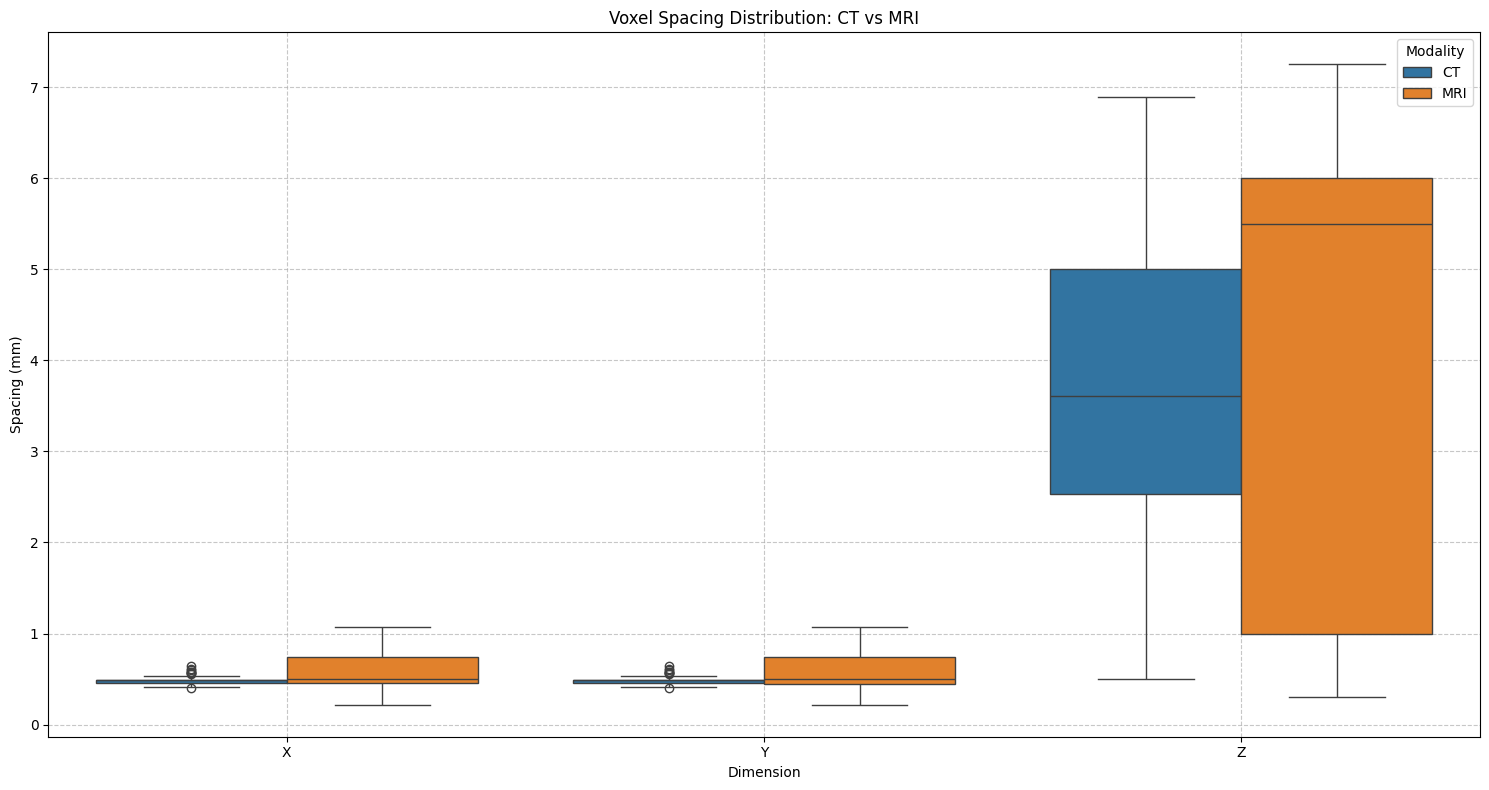

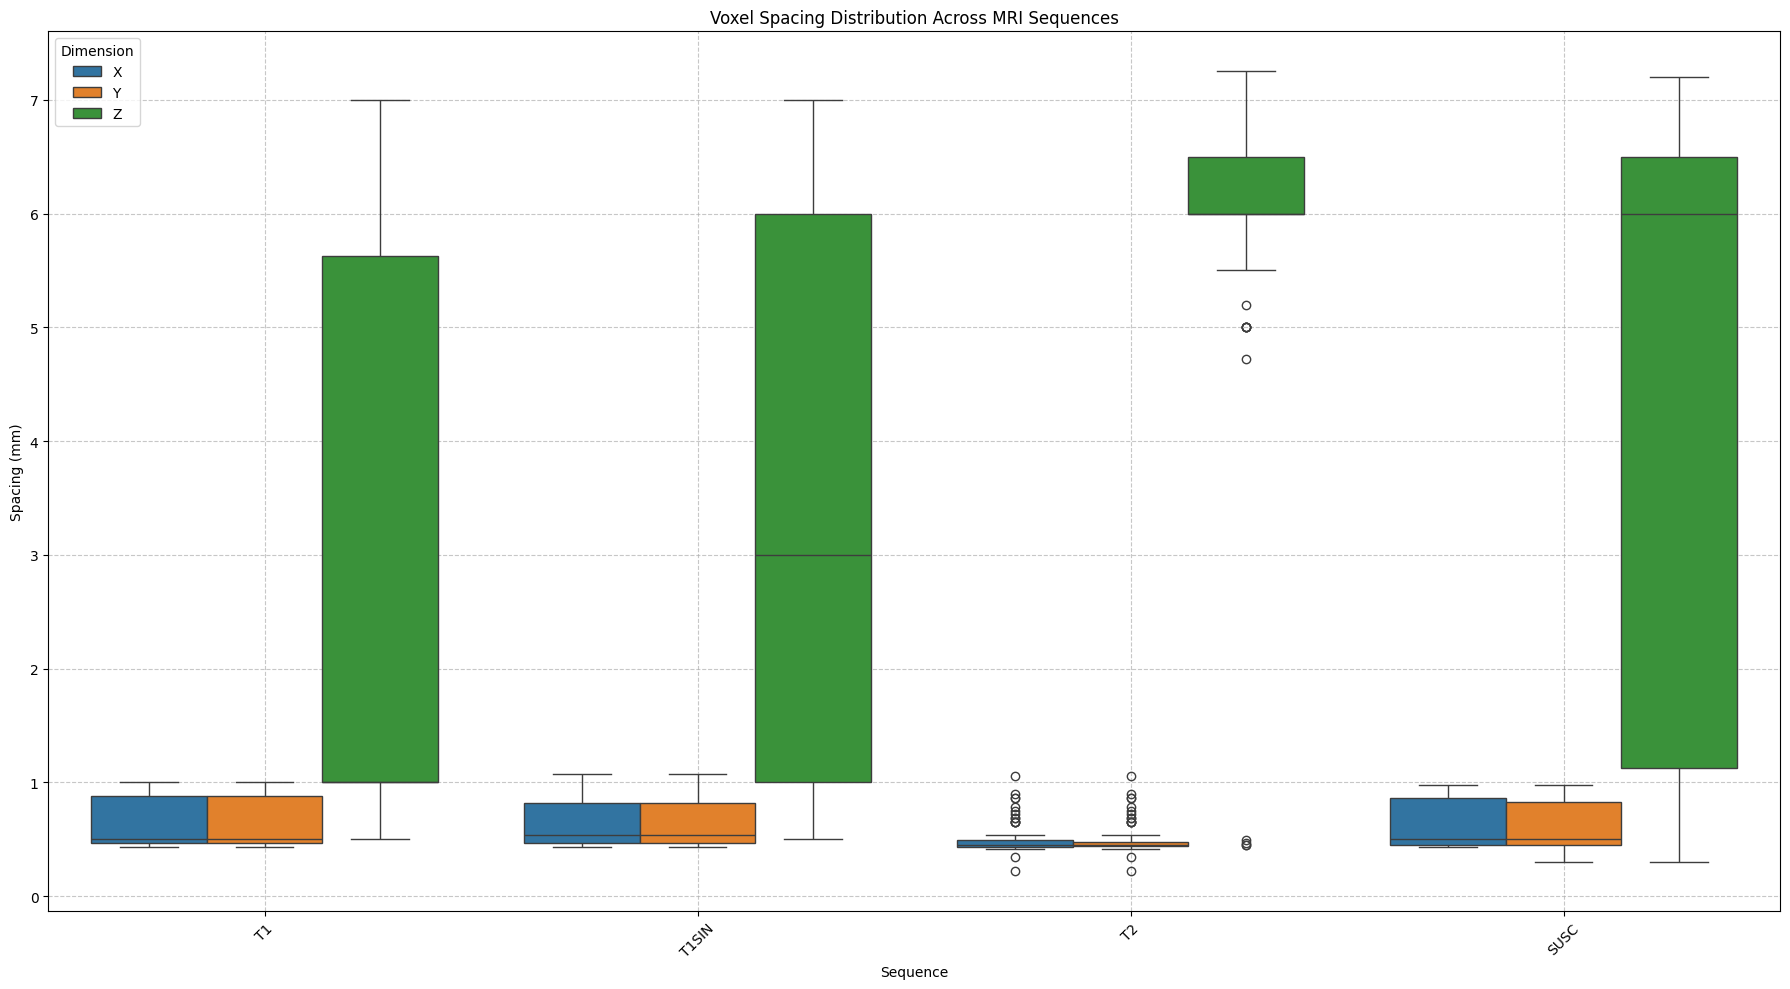

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nrrd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm

# Define the root directory for the dataset
dataset_root = '/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition'

# Function to extract voxel spacing from NRRD files
def get_voxel_spacing(file_path):
    try:
        header = nrrd.read_header(file_path)
        
        # Option 1: Direct spacing field
        spacing = header.get('spacing', None)
        
        # Option 2: Calculate from space directions
        if spacing is None:
            space_directions = header.get('space directions', None)
            if space_directions is not None:
                # Handle different space_directions formats
                try:
                    # For matrices stored as nested lists
                    spacing = [np.linalg.norm(np.array(vec, dtype=float)) for vec in space_directions]
                except TypeError:
                    # For matrices stored as numpy arrays or other formats
                    space_array = np.array(space_directions, dtype=float)
                    spacing = [np.linalg.norm(space_array[i]) for i in range(space_array.shape[0])]
            else:
                # Option 3: Use sizes and space origin if available
                sizes = header.get('sizes', None)
                if sizes is not None:
                    # Assuming uniform spacing if no direction info
                    # This is a fallback and might not be correct for all cases
                    print(f"Warning: Using uniform spacing for {file_path}")
                    return [1.0, 1.0, 1.0]
                return None
        
        return spacing
    except Exception as e:
        print(f"Error reading {file_path}: {str(e)}")
        return None

# Initialize lists to store data
data = []

# Process TC directory
tc_dir = os.path.join(dataset_root, 'TC')
if os.path.exists(tc_dir):
    # Get all patient directories
    patient_dirs = [d for d in os.listdir(tc_dir) if os.path.isdir(os.path.join(tc_dir, d)) and d.startswith('P')]
    
    for patient_dir_name in tqdm(patient_dirs, desc="Processing TC files"):
        patient_id = patient_dir_name
        patient_dir_path = os.path.join(tc_dir, patient_dir_name)
        scan_file = os.path.join(patient_dir_path, f"TC_{patient_id}.nrrd")
        
        if os.path.exists(scan_file):
            spacing = get_voxel_spacing(scan_file)
            if spacing:
                data.append({
                    'Patient': patient_id,
                    'Modality': 'CT',
                    'Sequence': 'N/A',
                    'X_spacing': spacing[0],
                    'Y_spacing': spacing[1],
                    'Z_spacing': spacing[2],
                    'File': scan_file
                })

# Process RM directory with its subdirectories
rm_dir = os.path.join(dataset_root, 'RM')
if os.path.exists(rm_dir):
    sequence_dirs = [d for d in os.listdir(rm_dir) if os.path.isdir(os.path.join(rm_dir, d))]
    
    for sequence_dir_name in sequence_dirs:
        sequence = sequence_dir_name
        sequence_dir_path = os.path.join(rm_dir, sequence_dir_name)
        
        # Get all patient directories for this sequence
        patient_dirs = [d for d in os.listdir(sequence_dir_path) 
                        if os.path.isdir(os.path.join(sequence_dir_path, d)) and d.startswith('P')]
        
        for patient_dir_name in tqdm(patient_dirs, desc=f"Processing MRI {sequence} files"):
            patient_id = patient_dir_name
            patient_dir_path = os.path.join(sequence_dir_path, patient_dir_name)
            scan_file = os.path.join(patient_dir_path, f"{sequence}_{patient_id}.nrrd")
            
            if os.path.exists(scan_file):
                spacing = get_voxel_spacing(scan_file)
                if spacing:
                    data.append({
                        'Patient': patient_id,
                        'Modality': 'MRI',
                        'Sequence': sequence,
                        'X_spacing': spacing[0],
                        'Y_spacing': spacing[1],
                        'Z_spacing': spacing[2],
                        'File': scan_file
                    })

# Create a DataFrame
df = pd.DataFrame(data)

# Display basic statistics
if not df.empty:
    print(f"Total scans analyzed: {len(df)}")
    print("\nVoxel spacing summary statistics (mm):")
    print(df[['X_spacing', 'Y_spacing', 'Z_spacing']].describe())
else:
    print("No data found. Please check the dataset path.")

# Save to CSV
df.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'voxel_spacing_analysis.csv'), index=False)
# Visualization of voxel spacing distribution across modalities and sequences
if not df.empty:
    # Melt the dataframe to make it suitable for box plots
    df_melted = pd.melt(
        df, 
        id_vars=['Modality', 'Sequence', 'Patient'], 
        value_vars=['X_spacing', 'Y_spacing', 'Z_spacing'],
        var_name='Dimension', 
        value_name='Spacing (mm)'
    )
    
    # Clean up dimension names for display
    df_melted['Dimension'] = df_melted['Dimension'].str.replace('_spacing', '')
    
    # Create box plots for CT vs MRI
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='Dimension', y='Spacing (mm)', hue='Modality', data=df_melted)
    plt.title('Voxel Spacing Distribution: CT vs MRI')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
# Visualization of voxel spacing across MRI sequences
if not df.empty and 'MRI' in df['Modality'].values:
    mri_data = df_melted[df_melted['Modality'] == 'MRI']
    
    plt.figure(figsize=(18, 10))
    sns.boxplot(x='Sequence', y='Spacing (mm)', hue='Dimension', data=mri_data)
    plt.title('Voxel Spacing Distribution Across MRI Sequences')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

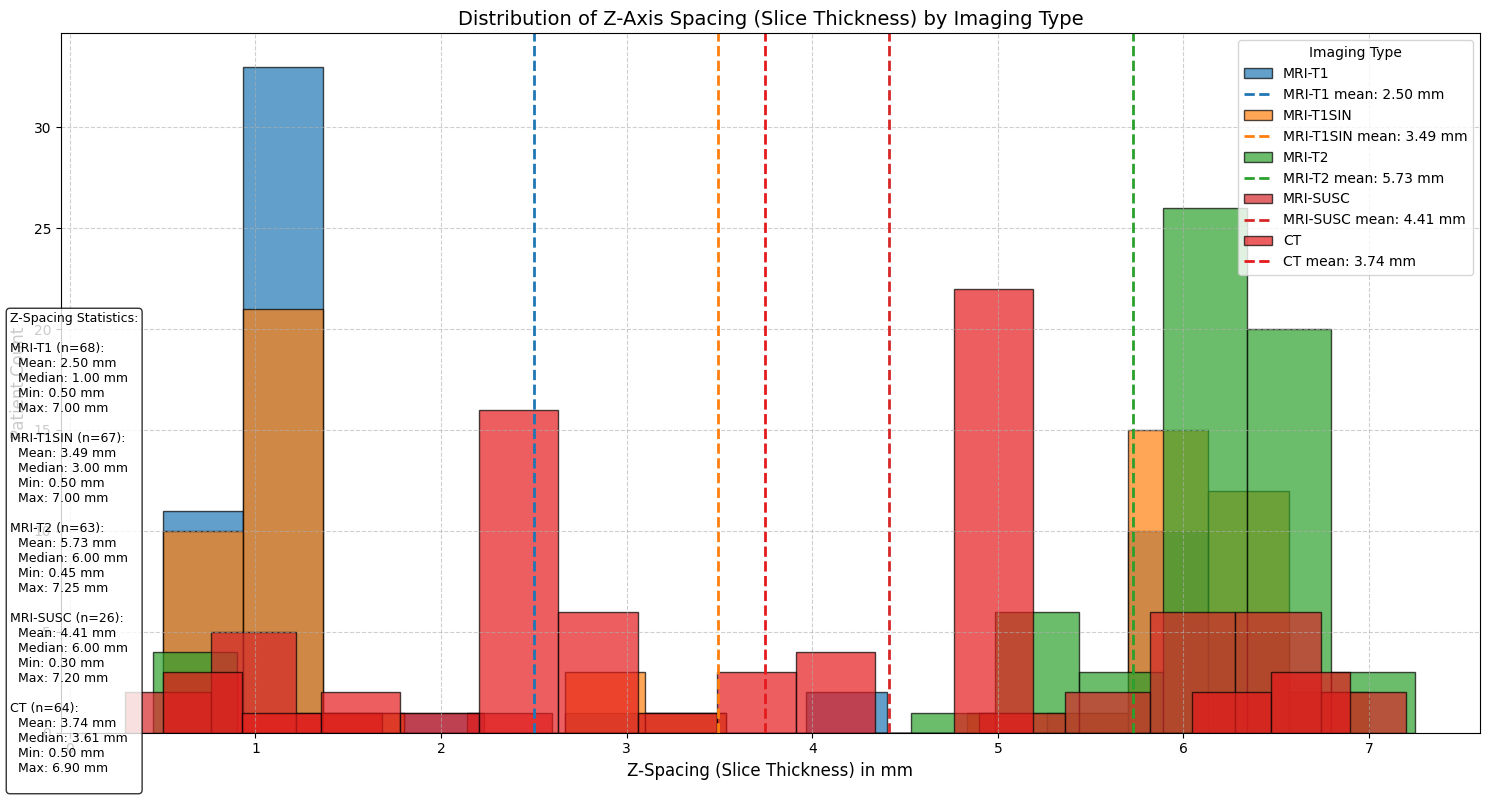

Z-Spacing Statistics by Imaging Type:

MRI Sequences:
          count      mean       std       min       25%       50%       75%  \
Sequence                                                                      
SUSC       26.0  4.413407  2.554211  0.299479  1.125125  5.999999  6.499998   
T1         68.0  2.502552  2.347128  0.500000  0.999997  1.000000  5.624994   
T1SIN      67.0  3.490072  2.614773  0.500000  0.999998  2.999997  6.000003   
T2         63.0  5.728982  1.476781  0.449219  5.999971  6.000001  6.500000   

               max  
Sequence            
SUSC      7.200002  
T1        7.000000  
T1SIN     7.000001  
T2        7.250001  

CT:
count    64.000000
mean      3.743796
std       1.540255
min       0.500000
25%       2.535248
50%       3.613499
75%       5.000000
max       6.896118
Name: Z_spacing, dtype: float64


In [12]:
# Histogram analysis focusing on Z-axis spacing by imaging modality and sequence
if not df.empty:
    # Setup the plot
    plt.figure(figsize=(15, 8))
    
    # Use different colors for each sequence/modality
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
    
    # Plot histograms for MRI sequences
    if 'MRI' in df['Modality'].values:
        mri_df = df[df['Modality'] == 'MRI']
        sequences = mri_df['Sequence'].unique()
        
        for i, seq in enumerate(sequences):
            seq_data = mri_df[mri_df['Sequence'] == seq]['Z_spacing']
            color = colors[i % len(colors)]
            
            # Plot histogram with transparency
            plt.hist(seq_data, bins=15, alpha=0.7, color=color, label=f'MRI-{seq}', 
                     edgecolor='black', linewidth=1)
            
            # Add a vertical line at the mean value
            mean_val = seq_data.mean()
            plt.axvline(x=mean_val, color=color, linestyle='--', 
                        linewidth=2, label=f'MRI-{seq} mean: {mean_val:.2f} mm')
    
    # Plot histogram for CT
    if 'CT' in df['Modality'].values:
        ct_df = df[df['Modality'] == 'CT']
        ct_data = ct_df['Z_spacing']
        
        # Use a distinctive color for CT
        ct_color = '#e41a1c'  # Red
        
        plt.hist(ct_data, bins=15, alpha=0.7, color=ct_color, label='CT', 
                 edgecolor='black', linewidth=1)
        
        # Add a vertical line at the mean value
        ct_mean = ct_data.mean()
        plt.axvline(x=ct_mean, color=ct_color, linestyle='--', 
                    linewidth=2, label=f'CT mean: {ct_mean:.2f} mm')
    
    # Add labels and title
    plt.xlabel('Z-Spacing (Slice Thickness) in mm', fontsize=12)
    plt.ylabel('Patient Count', fontsize=12)
    plt.title('Distribution of Z-Axis Spacing (Slice Thickness) by Imaging Type', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend
    plt.legend(title='Imaging Type', fontsize=10)
    
    # Display statistics in text box
    stats_text = "Z-Spacing Statistics:\n"
    
    # Add MRI sequence statistics
    if 'MRI' in df['Modality'].values:
        for seq in sequences:
            seq_data = mri_df[mri_df['Sequence'] == seq]['Z_spacing']
            stats_text += f"\nMRI-{seq} (n={len(seq_data)}):\n"
            stats_text += f"  Mean: {seq_data.mean():.2f} mm\n"
            stats_text += f"  Median: {seq_data.median():.2f} mm\n"
            stats_text += f"  Min: {seq_data.min():.2f} mm\n"
            stats_text += f"  Max: {seq_data.max():.2f} mm\n"
    
    # Add CT statistics
    if 'CT' in df['Modality'].values:
        stats_text += f"\nCT (n={len(ct_data)}):\n"
        stats_text += f"  Mean: {ct_data.mean():.2f} mm\n"
        stats_text += f"  Median: {ct_data.median():.2f} mm\n"
        stats_text += f"  Min: {ct_data.min():.2f} mm\n"
        stats_text += f"  Max: {ct_data.max():.2f} mm\n"
    
    plt.figtext(0.01, 0.01, stats_text, fontsize=9, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    
    plt.tight_layout()
    plt.show()
    
    # Display a table with statistics by imaging type
    print("Z-Spacing Statistics by Imaging Type:")
    
    if 'MRI' in df['Modality'].values:
        sequence_stats = mri_df.groupby('Sequence')['Z_spacing'].describe()
        print("\nMRI Sequences:")
        print(sequence_stats)
    
    if 'CT' in df['Modality'].values:
        ct_stats = ct_df['Z_spacing'].describe()
        print("\nCT:")
        print(ct_stats)

In [13]:
# Analysis of patients with all sequences having Z-spacing less than 1mm
if not df.empty:
    threshold = 1.0  # Spacing threshold in mm
    
    # Get unique patients
    all_patients = df['Patient'].unique()
    print(f"Total unique patients in dataset: {len(all_patients)}")
    
    # Find patients with all sequences having Z-spacing < threshold
    patients_with_all_under_threshold = []
    patients_with_some_under_threshold = []
    
    for patient in all_patients:
        patient_data = df[df['Patient'] == patient]
        
        # Check if all Z-spacings are below threshold
        if (patient_data['Z_spacing'] < threshold).all():
            patients_with_all_under_threshold.append(patient)
        elif (patient_data['Z_spacing'] < threshold).any():
            patients_with_some_under_threshold.append(patient)
    
    print(f"\nPatients with ALL sequences having Z-spacing < {threshold}mm: {len(patients_with_all_under_threshold)}")
    if patients_with_all_under_threshold:
        print("Patient IDs:", ", ".join(sorted(patients_with_all_under_threshold)))
        
        # Create a DataFrame with details for these patients
        sub_mm_df = df[df['Patient'].isin(patients_with_all_under_threshold)]
        print("\nDetailed information for patients with all sequences < 1mm:")
        pd.set_option('display.max_rows', None)  # Show all rows
        display(sub_mm_df.sort_values(['Patient', 'Modality', 'Sequence']))
    
    print(f"\nPatients with SOME (but not all) sequences having Z-spacing < {threshold}mm: {len(patients_with_some_under_threshold)}")
    
    # Additional analysis: How many sequences does each patient have?
    patient_sequence_counts = df.groupby('Patient').size()
    avg_sequences_per_patient = patient_sequence_counts.mean()
    print(f"\nAverage number of imaging sequences per patient: {avg_sequences_per_patient:.2f}")
    
    # Count patients with all MRI sequences
    if 'MRI' in df['Modality'].values:
        mri_sequences = df[df['Modality'] == 'MRI']['Sequence'].unique()
        print(f"Available MRI sequences: {', '.join(mri_sequences)}")
        
        patients_with_all_mri_sequences = []
        for patient in all_patients:
            patient_mri = df[(df['Patient'] == patient) & (df['Modality'] == 'MRI')]
            patient_sequences = set(patient_mri['Sequence'].unique())
            if patient_sequences == set(mri_sequences):
                patients_with_all_mri_sequences.append(patient)
        
        print(f"Patients with all available MRI sequences: {len(patients_with_all_mri_sequences)}")
        
        # Find patients with all MRI sequences AND CT scan
        if 'CT' in df['Modality'].values:
            patients_with_all_imaging = []
            for patient in patients_with_all_mri_sequences:
                if patient in df[df['Modality'] == 'CT']['Patient'].values:
                    patients_with_all_imaging.append(patient)
            
            print(f"Patients with both all MRI sequences AND CT scan: {len(patients_with_all_imaging)}")
            
            # Of these complete patients, how many have all with sub-1mm spacing?
            complete_sub_mm_patients = set(patients_with_all_imaging) & set(patients_with_all_under_threshold)
            print(f"Patients with complete imaging (all MRI+CT) AND all sub-{threshold}mm spacing: {len(complete_sub_mm_patients)}")
            if complete_sub_mm_patients:
                print("Patient IDs:", ", ".join(sorted(complete_sub_mm_patients)))

Total unique patients in dataset: 69

Patients with ALL sequences having Z-spacing < 1.0mm: 0

Patients with SOME (but not all) sequences having Z-spacing < 1.0mm: 33

Average number of imaging sequences per patient: 4.17
Available MRI sequences: T1, T1SIN, T2, SUSC
Patients with all available MRI sequences: 24
Patients with both all MRI sequences AND CT scan: 23
Patients with complete imaging (all MRI+CT) AND all sub-1.0mm spacing: 0


/tmp/ipykernel_106699/2857281568.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




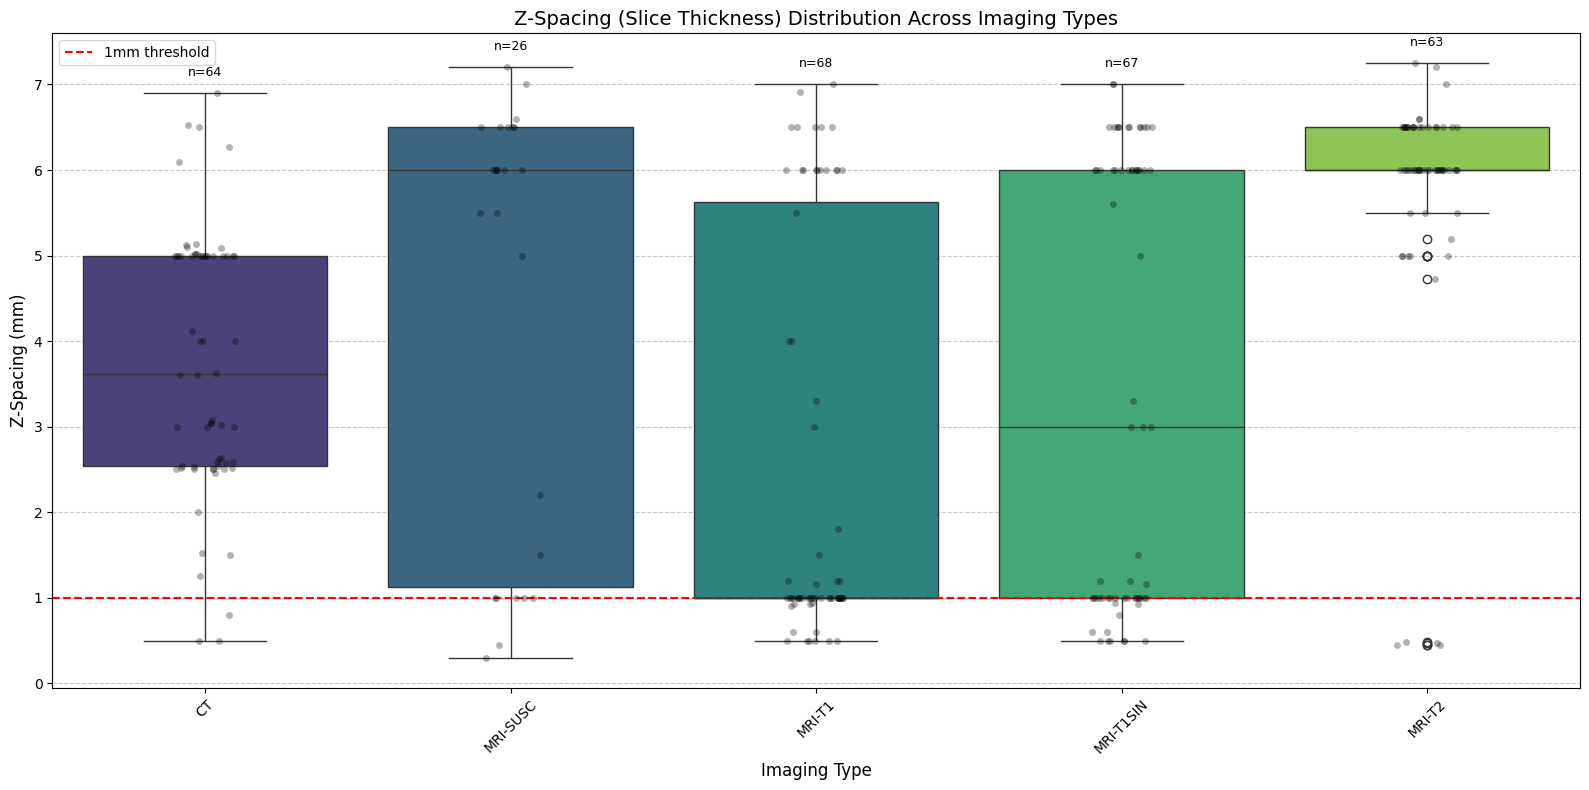

In [14]:
# Box plot comparing Z-spacing across all imaging types
if not df.empty:
    plt.figure(figsize=(16, 8))
    
    # Create a combined field for modality-sequence
    plot_df = df.copy()
    # For MRI, combine modality and sequence
    plot_df.loc[plot_df['Modality'] == 'MRI', 'Imaging_Type'] = 'MRI-' + plot_df.loc[plot_df['Modality'] == 'MRI', 'Sequence']
    # For CT, just use 'CT'
    plot_df.loc[plot_df['Modality'] == 'CT', 'Imaging_Type'] = 'CT'
    
    # Sort types for better visualization
    imaging_types = ['CT'] + sorted([t for t in plot_df['Imaging_Type'].unique() if t != 'CT'])
    
    # Create box plot
    sns.boxplot(x='Imaging_Type', y='Z_spacing', data=plot_df, order=imaging_types, palette='viridis')
    
    # Add individual points for better visualization
    sns.stripplot(x='Imaging_Type', y='Z_spacing', data=plot_df, order=imaging_types, 
                 color='black', alpha=0.3, jitter=True)
    
    # Add a horizontal line at 1mm threshold
    plt.axhline(y=1.0, color='red', linestyle='--', label='1mm threshold')
    
    # Customize plot
    plt.title('Z-Spacing (Slice Thickness) Distribution Across Imaging Types', fontsize=14)
    plt.xlabel('Imaging Type', fontsize=12)
    plt.ylabel('Z-Spacing (mm)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.xticks(rotation=45)
    plt.legend()
    
    # Add count annotations
    ax = plt.gca()
    for i, typ in enumerate(imaging_types):
        count = len(plot_df[plot_df['Imaging_Type'] == typ])
        ax.text(i, plot_df[plot_df['Imaging_Type'] == typ]['Z_spacing'].max() + 0.2, 
                f'n={count}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

usage: ipykernel_launcher.py [-h] --dataset DATASET [--threshold THRESHOLD]
                             [--output OUTPUT]
ipykernel_launcher.py: error: the following arguments are required: --dataset/-d


SystemExit: 2

/home/mariopasc/Python/misc/miniconda3/envs/meningiomas/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.

